# Meridional Overturning

`mom6_tools.moc` functions for computing and plotting meridional overturning. 

The goal of this notebook is the following:

1) server as an example on to compute a meridional overturning streamfunction (global and Atalntic) from CESM/MOM output; 

2) evaluate model experiments by comparing transports against observed estimates;

3) compare model results vs. another model results (TODO).

In [1]:
%matplotlib inline
import matplotlib
import numpy as np
import xarray as xr
# mom6_tools
from mom6_tools.moc import  *
from mom6_tools.m6toolbox import check_time_interval, genBasinMasks 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# The following parameters must be set accordingly
######################################################
# case name - must be changed for each configuration
case_name = 'g.c2b6.GJRA.TL319_t061.long_JRA_mct.001'
# Path to the run directory
path = "/glade/scratch/gmarques/"+case_name+"/run/"
# initial and final years for computing time mean
year_start = 1
year_end = 60
# add your name and email address below
author = 'Gustavo Marques (gmarques@ucar.edu)'
######################################################
# create an empty class object
class args:
  pass

args.infile = path
args.static = case_name+'.mom6.static.nc'
args.monthly = case_name+'.mom6.hm_*nc'
args.year_start = year_start
args.year_end = year_end
args.case_name = case_name
args.label = ''
args.savefigs = False

In [3]:
stream = True
# mom6 grid
grd = MOM6grid(args.infile+args.static)
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[numpy.isnan(depth)] = 0.0
basin_code = m6toolbox.genBasinMasks(grd.geolon, grd.geolat, depth)

# load data
ds = xr.open_mfdataset(args.infile+args.monthly,decode_times=False)
# convert time in years
ds['time'] = ds.time/365.
ti = args.year_start
tf = args.year_end
# check if data includes years between ti and tf
check_time_interval(ti,tf,ds)

# create a ndarray subclass
class C(numpy.ndarray): pass

if 'vmo' in ds.variables:
  varName = 'vmo'; conversion_factor = 1.e-9
elif 'vh' in ds.variables:
  varName = 'vh'; conversion_factor = 1.e-6
  if 'zw' in ds.variables: conversion_factor = 1.e-9 # Backwards compatible for when we had wrong units for 'vh'
else: raise Exception('Could not find "vh" or "vmo" in file "%s"'%(args.infile+args.static))
  

tmp = np.ma.masked_invalid(ds[varName].sel(time=slice(ti,tf)).mean('time').data)
tmp = tmp[:].filled(0.)
VHmod = tmp.view(C)
VHmod.units = ds[varName].units


Zmod = m6toolbox.get_z(ds, depth, varName)

if args.case_name != '':  case_name = args.case_name + ' ' + args.label
else: case_name = rootGroup.title + ' ' + args.label


MOM6 grid successfully loaded... 

11.16428 64.78855 [391, 434]


## Global MOC

(63, 458) (63, 458) (63, 458)


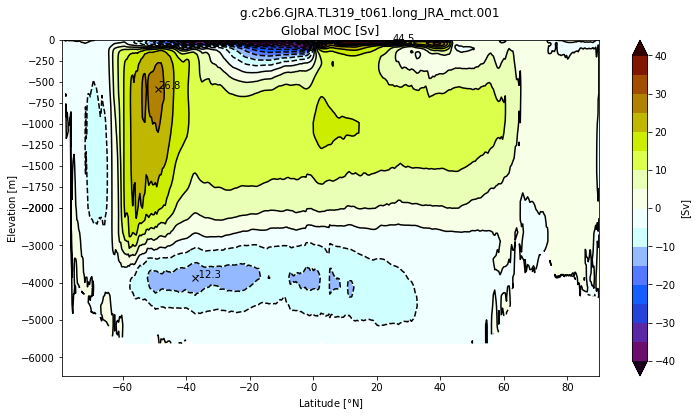

In [4]:
# Global MOC
m6plot.setFigureSize([16,9],576,debug=False)
axis = plt.gca()
cmap = plt.get_cmap('dunnePM')
z = Zmod.min(axis=-1); psiPlot = MOCpsi(VHmod)*conversion_factor
psiPlot = 0.5 * (psiPlot[0:-1,:]+psiPlot[1::,:])
#yy = y[1:,:].max(axis=-1)+0*z
yy = grd.geolat_c[:,:].max(axis=-1)+0*z

ci=m6plot.pmCI(0.,40.,5.)
plotPsi(yy, z, psiPlot, ci, 'Global MOC [Sv]')
plt.xlabel(r'Latitude [$\degree$N]')
plt.suptitle(case_name)
print(yy.shape, z.shape, psiPlot.shape)
findExtrema(yy, z, psiPlot, max_lat=-30.)
findExtrema(yy, z, psiPlot, min_lat=25.)
findExtrema(yy, z, psiPlot, min_depth=2000., mult=-1.)

## Atlantic MOC

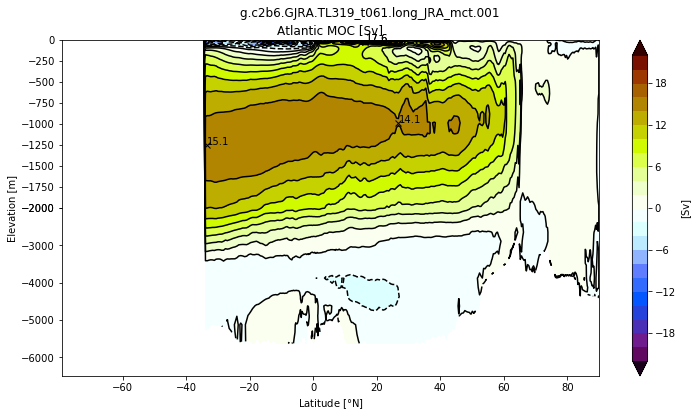

In [5]:
m6plot.setFigureSize([16,9],576,debug=False)
cmap = plt.get_cmap('dunnePM')
m = 0*basin_code; m[(basin_code==2) | (basin_code==4) | (basin_code==6) | (basin_code==7) | (basin_code==8)]=1
ci=m6plot.pmCI(0.,22.,2.)
z = (m*Zmod).min(axis=-1); psiPlot = MOCpsi(VHmod, vmsk=m*numpy.roll(m,-1,axis=-2))*conversion_factor
psiPlot = 0.5 * (psiPlot[0:-1,:]+psiPlot[1::,:])
#yy = y[1:,:].max(axis=-1)+0*z
yy = grd.geolat_c[:,:].max(axis=-1)+0*z
plotPsi(yy, z, psiPlot, ci, 'Atlantic MOC [Sv]')
plt.xlabel(r'Latitude [$\degree$N]')
plt.suptitle(case_name)
findExtrema(yy, z, psiPlot, min_lat=26.5, max_lat=27.) # RAPID
findExtrema(yy, z, psiPlot, max_lat=-33.)
findExtrema(yy, z, psiPlot)
findExtrema(yy, z, psiPlot, min_lat=5.)

## MOC time series

In [13]:
dtime = ds.time.values

amoc_26 = np.zeros(len(dtime))
amoc_45 = np.zeros(len(dtime))

# loop in time
for t in range(len(dtime)):
    tmp = np.ma.masked_invalid(ds[varName].sel(time=dtime[t]).values)
    tmp = tmp[:].filled(0.)
    psi = MOCpsi(tmp, vmsk=m*numpy.roll(m,-1,axis=-2))*conversion_factor
    psi = 0.5 * (psi[0:-1,:]+psi[1::,:])
    amoc_26[t] = findExtrema(yy, z, psi, min_lat=26.5, max_lat=27., plot=False)
    amoc_45[t] = findExtrema(yy, z, psi, min_lat=44., max_lat=46., plot=False)

### AMOC @ 26 $^o$ N

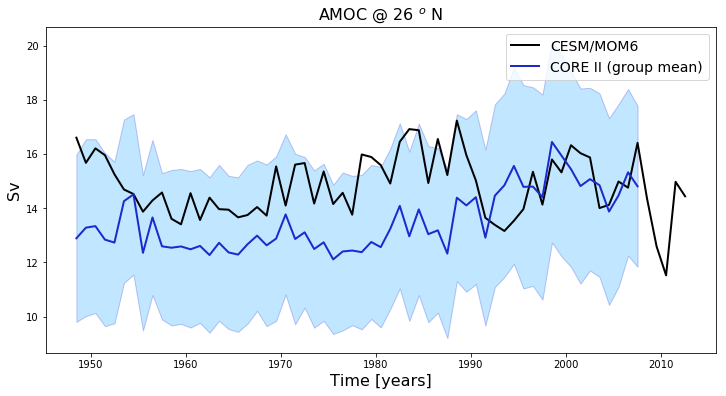

In [44]:
# load AMOC time series data (5th) cycle used in Danabasoglu et al., doi:10.1016/j.ocemod.2015.11.007
path = '/glade/p/cesm/omwg/amoc/COREII_AMOC_papers/papers/COREII.variability/data.original/'
amoc_core_26 = xr.open_dataset(path+'AMOCts.cyc5.26p5.nc')

# plot
fig = plt.figure(figsize=(12, 6))
plt.plot(dtime+1948.,amoc_26, color='k', label='CESM/MOM6', lw=2)
# core data
core_mean = amoc_core_26['MOC'].mean(axis=0).data
core_std = amoc_core_26['MOC'].std(axis=0).data
plt.plot(amoc_core_26.time,core_mean, 'k', label='CORE II (group mean)', color='#1B2ACC', lw=2)
plt.fill_between(amoc_core_26.time, core_mean-core_std, core_mean+core_std,
    alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.title('AMOC @ 26 $^o$ N', fontsize=16)
plt.xlabel('Time [years]', fontsize=16); plt.ylabel('Sv', fontsize=16)
plt.legend(fontsize=14)

### AMOC @ 45 $^o$ N

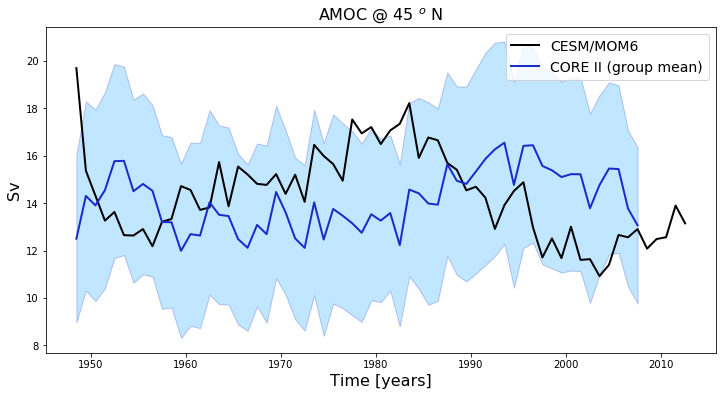

In [45]:
amoc_core_45 = xr.open_dataset(path+'AMOCts.cyc5.45.nc')

# plot
fig = plt.figure(figsize=(12, 6))
plt.plot(dtime+1948.,amoc_45, color='k', label='CESM/MOM6', lw=2)
# core data
core_mean = amoc_core_45['MOC'].mean(axis=0).data
core_std = amoc_core_45['MOC'].std(axis=0).data
plt.plot(amoc_core_45.time,core_mean, 'k', label='CORE II (group mean)', color='#1B2ACC', lw=2)
plt.fill_between(amoc_core_45.time, core_mean-core_std, core_mean+core_std,
    alpha=0.25, edgecolor='#1B2ACC', facecolor='#089FFF')
plt.title('AMOC @ 45 $^o$ N', fontsize=16)
plt.xlabel('Time [years]', fontsize=16); plt.ylabel('Sv', fontsize=16)
plt.legend(fontsize=14)